In [1]:
#Bibliotheken einbinden
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

# Definieren von Sensorenreihenfolge, -höhe, Bezeichnung in Exceltabellen
sensoren_gesamt = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Excelbezeichnung (Reihenfolge identisch wie Skizzenliste)
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Umwandeln in Dictionary
skizze_to_excel = dict(zip(sensoren_gesamt, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_gesamt))

#Sensoren im Teilquerschnitt nach Skizzenbezeichnung
sensoren_aussen = ["T4", "T5", "T6", "T10", "T11", "T12", "T16", "T18"] # ohne T7-9 (zu extreme Werte)
sensoren_innen = ["T1", "T2", "T3", "T13", "T14", "T15", "T17", "T19"]  # ohne T7-9 (zu extreme Werte)
sensoren_oben = ["T7", "T8", "T9"]
sensoren_links_innen = ["T1", "T2", "T3", "T19"]
sensoren_links_aussen = ["T4", "T5", "T6", "T18"]
sensoren_rechts_innen   = ["T13", "T14", "T15", "T17"]
sensoren_rechts_aussen  = ["T10", "T11", "T12", "T16"]
sensoren_gesamt_ohneOben = [
    s for s in sensoren_gesamt
    if s not in sensoren_oben
]
sensoren_links = sensoren_links_innen + sensoren_links_aussen
sensoren_rechts = sensoren_rechts_innen + sensoren_rechts_aussen

#Sensorhöhen nach Skizzenbezeichnung (UK Stege als 0,00 definiert)
sensor_hoehen = {
"TL": 0.25, #TL
"T1": 1.25, "T2": 0.75, "T3": 0.25, "T4": 0.25, "T5": 0.75, "T6": 1.25, #T1-6
"T7": 1.71, "T8": 1.81, "T9": 1.91, #T7-9
"T10": 1.25, "T11": 0.75, "T12": 0.25, "T13": 0.25, "T14": 0.75, "T15": 1.25, #T10-15
"T16": 1.5, "T17": 1.6, #T16-17
"T18": 1.5, "T19": 1.6, #T18-19
}

# Hilfsfunktion: Daten laden (in Skizzenbezeichnung)
def lade_df(sensorliste, start, ende):
    excel_spalten = [skizze_to_excel[s] for s in sensorliste]
    df = gesamt_df.loc[start:ende, excel_spalten]
    df = df.rename(columns=excel_to_skizze)
    return df[sensorliste]

# Hilfsfunktion: beliebige Liste in Skizzenbezeichnung über die Höhe sortieren
def sensoren_nach_hoehe(sensorliste):
    return sorted(sensorliste, key=lambda s: sensor_hoehen[s])

# Hilfsfunktion: Gradienten berechnen
def berechne_gradient(df, sensorliste):

    #Sensorliste und Höhenliste müssen in gleicher Reihenfolge vorhanden sein
    sensorliste_sortiert = sensoren_nach_hoehe(sensorliste)
    hoehen = np.array([sensor_hoehen[s] for s in sensorliste_sortiert])

    # für Performance: Pandas-DataFrame --> NumPy-Array
    werte = df[sensorliste_sortiert].to_numpy()
    
    gradients = np.full(len(df), np.nan)
    
    # für jeden Zeitschritt wird für jede Sensorliste eine lin. Funktion berechnet (Temp. über Höhe)
    # VEREINFACHUNG: Linearer Temperaturverlauf über die Bauteilhöhe
    for i in range(werte.shape[0]):
        temperaturen = werte[i]
        gueltig = ~np.isnan(temperaturen)

        # Gradient kann nur berechnet werden, wenn min. zwei Sensoren in untersch. Höhen vorh. sind
        if np.sum(gueltig) >= 2:
            # Steigung dT/dz; Einheit: [K/m]
            # Steigung wird gespeichert, andere Werte verworfen
            # WICHTIG: Befinden sich mehrere Sensoren auf derselben Höhe, wirken diese als Stützpunkte mit höherer Gewichtung. Die Regressionsgerade verläuft dann tendenziell durch deren arithmetisches Mittel an diesem Punkt
            steigung, _ = np.polyfit(
                hoehen[gueltig],
                temperaturen[gueltig],
                1
            )
            gradients[i] = steigung
    return pd.Series(gradients, index=df.index)

In [28]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren

#window_size = 6  # Rolling Median: Zusammenfassen von 6 Messwerten zu einem (30 Min)
#gesamt_df[temp_spalten] = gesamt_df[temp_spalten].rolling(window=window_size, center=True).median()

In [3]:
# Plot der Temperaturdifferenzen zu TL
def vergleich_sensoren_TL(start, ende):
    # Sensordaten in Skizzenreihenfolge holen
    werte=lade_df(sensoren_gesamt, start,ende)
    
    # DataFrame mit Skizzenbezeichnungen erzeugen
    df_skizze = pd.DataFrame(
        werte,
        index=gesamt_df.index,
        columns=sensoren_gesamt
    )
    
    # Temperaturdifferenzen relativ zu TL
    df_diff = df_skizze.sub(df_skizze["TL"], axis=0)
    
    df_diff.loc[start:ende].plot(
        figsize=(14, 6),
        title="Temperaturdifferenzen relativ zu TL",
    )
    
    plt.ylabel("ΔT [°C]")
    plt.xlabel("Zeit")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

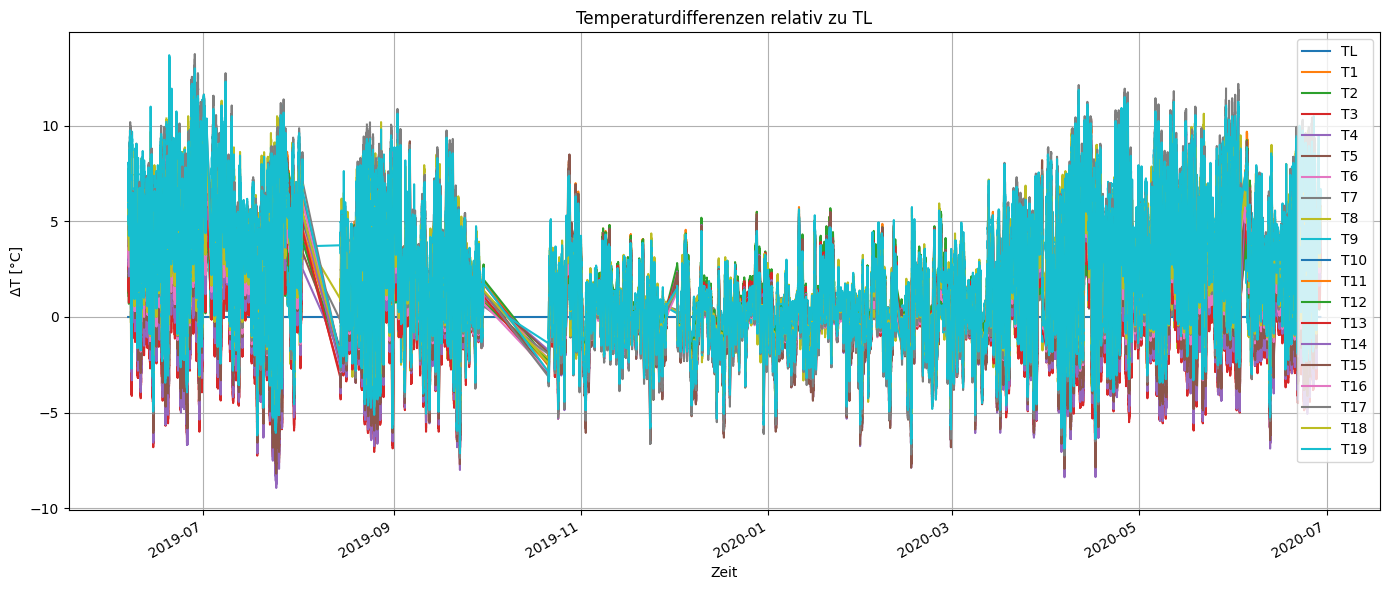

In [4]:
vergleich_sensoren_TL("2019-06-06","2020-06-28")
# erster Überblick über die Sensorenwerte; auch bei folgenden Funktionen war uns Flexibilität bei der Wahl des Zeitraums wichtig --> sehr grobe, übergeordnete Polts über den gesamten Zeitraum vs. detaillierte Plots über ausgewählte Stunden/ Tage/ Wochen/ Monate 
# Brückentemp. unterscheidet sich max. mit 14 K bzw -9 K zur Umgebungstemperatur
# im August, Oktober und Dezember wurden abschnittsweise keine Werte aufgezeichnet
# Abweichungen sind im Winter kleiner als im Sommer (sowohl pos. als auch neg.)

In [5]:
# Plottet mittlere absolute Sensortemperaturen über der Höhe
def plot_mitteltemperaturen(start, ende):
    # Daten laden
    df_skizze = lade_df(sensoren_gesamt, start, ende)
    mittelwerte = df_skizze.mean()

    # Plot
    plt.figure(figsize=(6, 9))

    def plot_gruppe(sensorliste, farbe, label):
        first = True
        for s in sensorliste:
            if s in mittelwerte.index:
                plt.scatter(
                    mittelwerte[s],
                    sensor_hoehen[s],
                    color=farbe,
                    s=60,
                    label=label if first else None
                )
                plt.text(
                    mittelwerte[s] - 0.07,
                    sensor_hoehen[s] + 0.03,
                    s,
                    fontsize=9,
                    va="center"
                )
                first = False

    plot_gruppe(sensoren_links, "green", "linker Teilquerschnitt")
    plot_gruppe(sensoren_rechts, "purple", "rechter Teilquerschnitt")
    plot_gruppe(sensoren_oben, "orange", "obere Sensoren")


    # Achsen & Layout
    plt.xlabel("Temperatur [°C]")
    plt.ylabel("Höhe z [m]")
    plt.grid(True)
    plt.legend()
    plt.title("Mittlere Sensortemperaturen\n"+start+" bis "+ende)
    plt.tight_layout()
    plt.show()

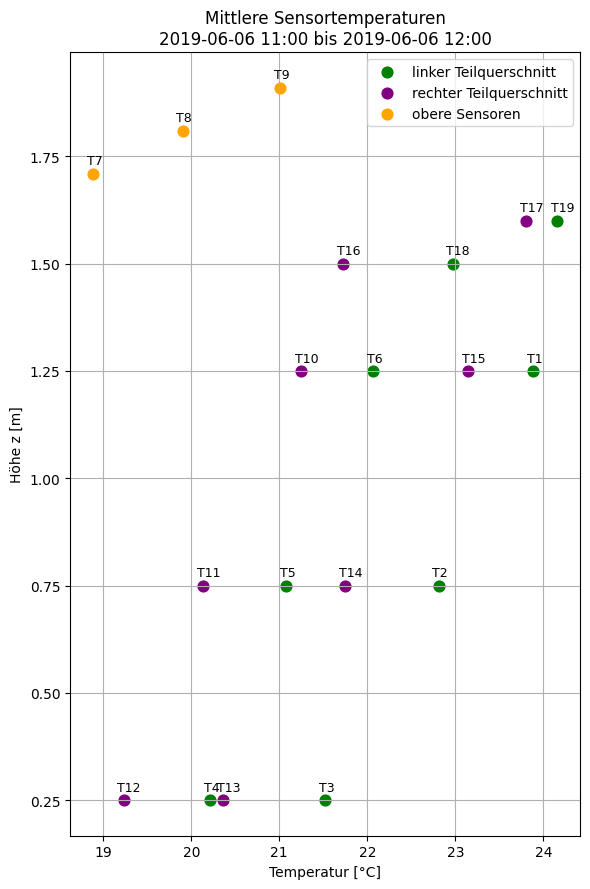

In [6]:
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
)
# Sensoren im linken Teil-QS sind an dem Morgen ca 1 K wärmer als die gespiegelten Sensoren im rechten Teil-QS --> wird von der Sonne aus dem Osten bestrahlt
# Fahrbahn wird ebenso von der Sonne (im kleineren Winkel) getroffen --> Temperaturgradient von T9-T7; Wärme wird in Bauteilinneres getragen
# unten ist es nach der Nacht tendentiell kälter

In [7]:
"""
    Plottet vereinheitlichte Temperatur-Heatmaps:
    1) Gesamtquerschnitt absolut (nach Höhe sortiert)
    2) ΔT linker Teilquerschnitt relativ zum Gesamt-QS
    3) ΔT rechter Teilquerschnitt relativ zum Gesamt-QS
    4) Gesamtquerschnitt relativ zu TL
"""
def plot_temperatur_heatmap(start, ende):
    df_gesamt = lade_df(sensoren_gesamt, start, ende)
    df_links  = lade_df(sensoren_links, start, ende)
    df_rechts = lade_df(sensoren_rechts, start, ende)

    # Colormaps
    cmap_abs = mcolors.LinearSegmentedColormap.from_list(
        "abs",
        ["black", "darkblue", "turquoise", "green", "yellow", "red"]
    )

    cmap_delta = mcolors.LinearSegmentedColormap.from_list(
        "delta",
        ["cyan", "blue", "white", "orange", "red"]
    )

    # Zeitachse
    xticks = np.linspace(0, len(df_gesamt.index) - 1, 10)
    xtick_labels = [
        df_gesamt.index[int(i)].strftime("%d.%m.%Y %H:%M")
        for i in xticks
    ]

    # Die Liste der Sensoren nach Höhe sortieren
    # diese Liste dient als Index für die Spalten
    sensoren_sortiert = sensoren_nach_hoehe(sensoren_gesamt)
    
    # Mittelwert über alle Sensoren für die relativen Plots 3 und 4
    gesamt_mittel = df_gesamt.mean(axis=1)
    
    # PLOT 1: Heatmap – Gesamt absolut; nach Höhe sortiert
    plt.figure(figsize=(14, 6))
    
    # df_gesamt[sensoren_sortiert] sortiert die Spalten, .T macht sie zur Y-Achse
    im = plt.imshow(df_gesamt[sensoren_sortiert].T, aspect="auto", origin="lower", cmap=cmap_abs)
    plt.colorbar(im, label="Temperatur [°C]")
    
    plt.yticks(
        np.arange(len(sensoren_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (nach Höhe sortiert)")
    plt.title("Absolute Temperaturen im Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()
    
    
    # PLOT 2: Heatmap – Gesamt relativ zu TL; nach Höhe sortiert
    df_gesamt_relativ = df_gesamt.sub(df_gesamt["TL"], axis=0)
    df_plot_relativ = df_gesamt_relativ[sensoren_sortiert]
    
    vmax = np.nanmax(np.abs(df_plot_relativ.values))
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_plot_relativ.T, 
        aspect="auto", 
        origin="lower", 
        cmap=cmap_delta, 
        vmin=-vmax, 
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT relativ zu TL [°C]")
    
    plt.yticks(
        np.arange(len(sensoren_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (nach Höhe sortiert)")
    plt.title("Gesamtquerschnitt in Relation zu TL")
    plt.tight_layout()
    plt.show()

    # PLOT 3 Heatmap – Links relativ zu Gesamt
    df_links_relativ = df_links.sub(gesamt_mittel, axis=0)
    
    # Spalten nach Höhe sortieren
    sensoren_links_sortiert = sensoren_nach_hoehe(list(df_links_relativ.columns))
    df_links_relativ = df_links_relativ[sensoren_links_sortiert]

    vmax = np.nanmax(np.abs(df_links_relativ.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_links_relativ.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT links – Gesamt [°C]")

    # Y-Ticks passend zur sortierten Liste setzen
    plt.yticks(
        np.arange(len(sensoren_links_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_links_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Linker Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

    # PLOT 4 Heatmap – Rechts relativ zu Gesamt
    df_rechts_relativ = df_rechts.sub(gesamt_mittel, axis=0)
    
    # Spalten nach Höhe sortieren
    sensoren_rechts_sortiert = sensoren_nach_hoehe(list(df_rechts_relativ.columns))
    df_rechts_relativ = df_rechts_relativ[sensoren_rechts_sortiert]

    vmax = np.nanmax(np.abs(df_rechts_relativ.values))

    plt.figure(figsize=(14, 6))
    im = plt.imshow(
        df_rechts_relativ.T,
        aspect="auto",
        origin="lower",
        cmap=cmap_delta,
        vmin=-vmax,
        vmax=vmax
    )
    plt.colorbar(im, label="ΔT rechts – Gesamt [°C]")

    # Y-Ticks passend zur sortierten Liste setzen
    plt.yticks(
        np.arange(len(sensoren_rechts_sortiert)),
        [f"{s} (z={sensor_hoehen[s]:.2f} m)" for s in sensoren_rechts_sortiert]
    )
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel("Zeit")
    plt.ylabel("Sensor")
    plt.title("Rechter Teilquerschnitt in Relation zum Gesamtquerschnitt")
    plt.tight_layout()
    plt.show()

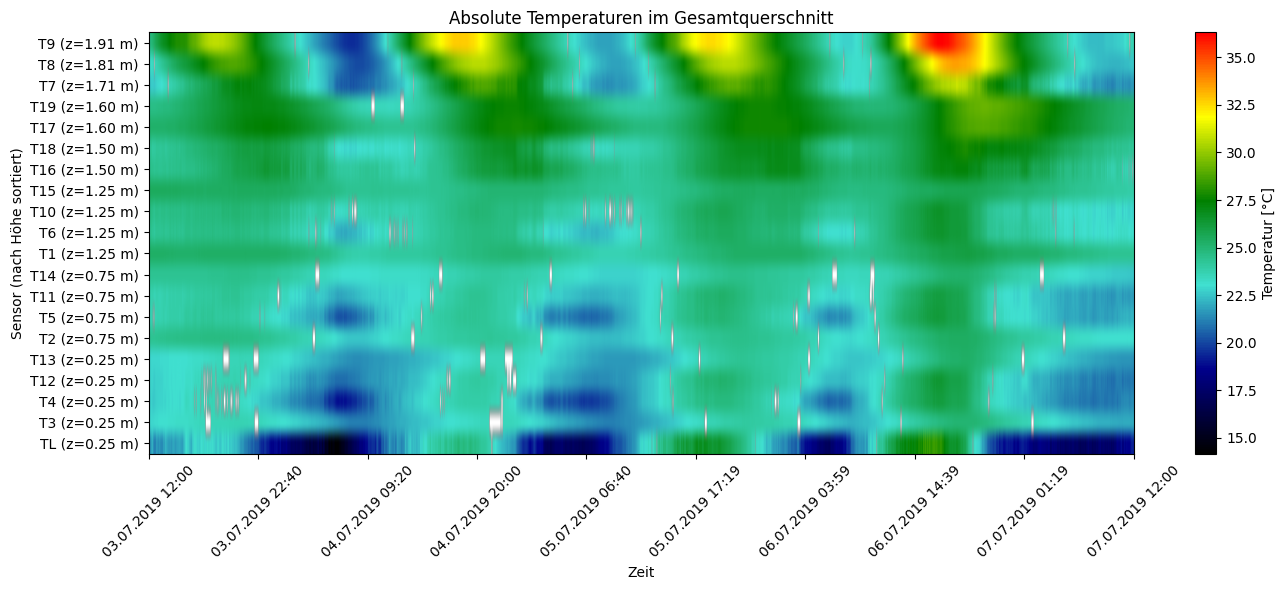

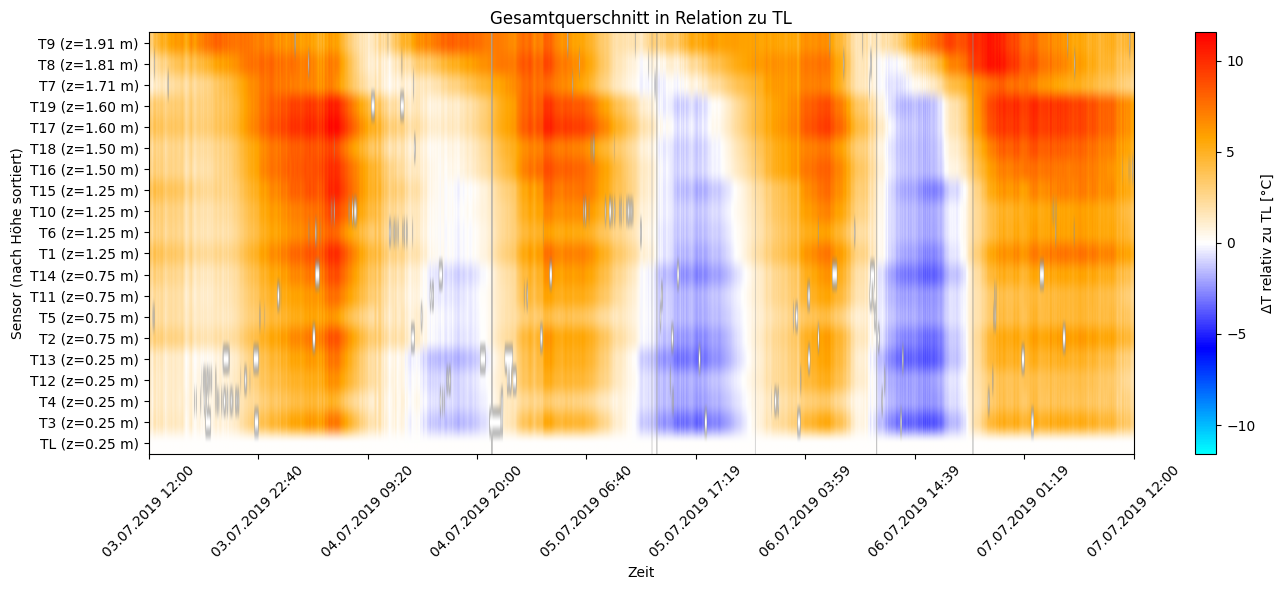

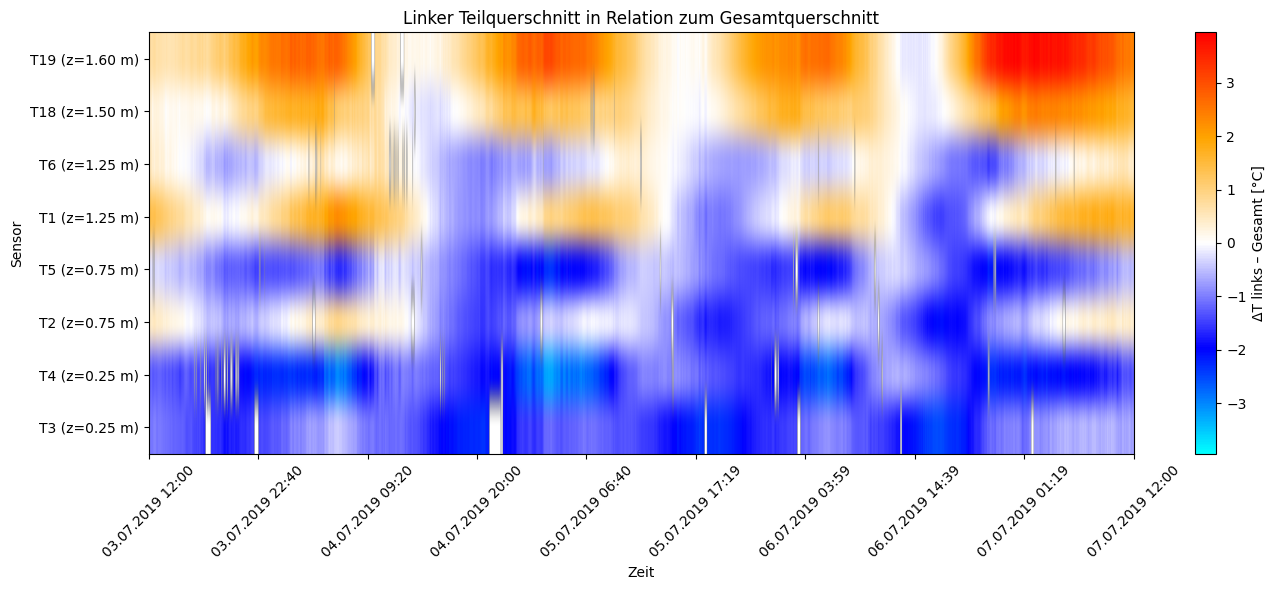

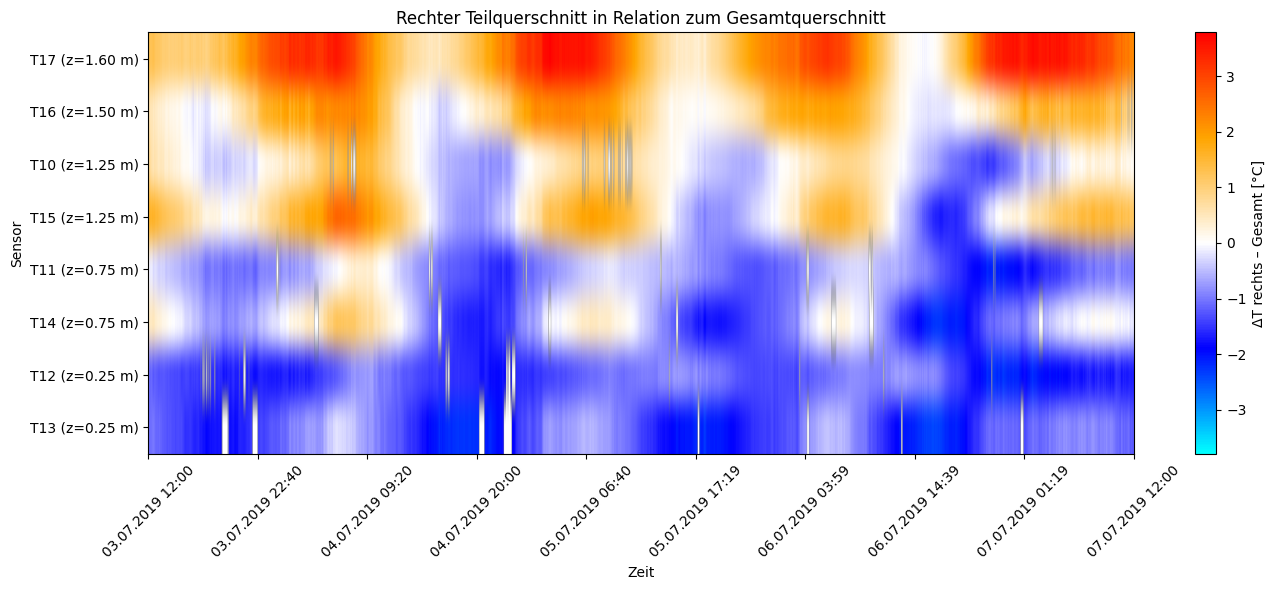

In [29]:
# Heatmaps zu Gesamt- und Teilquerschnitt
# absolut und relativ
plot_temperatur_heatmap("2019-07-03 12:00", "2019-07-07  12:00")
# Allgemein

# Sommer
# oben tagsüber mit Abstand am wärmsten --> direkte Sonneneinstrahlung; nachts fällt Temp. schnell wieder auf Umgebungstemperatur
# Außensensoren schwanken stärker als Innensensoren, insb. bei kurzfristigen Ereignissen (Wechsel zwischen Sonne, Wolken, Regen, Wind)
# je tiefer Sensoren im Bauteilinneren liegen, desto später erreichen sie Temperaturänderungen

In [33]:
def temperaturgradient(start, ende):
    
    # Daten laden (Skizzenbezeichnung)
    df_roh = lade_df(sensoren_gesamt, start, ende)
    
    # Rolling Median anwenden (nur hier lokal in dieser Funktion)
    # 6 aufeinanderfolgende Werte werden zu einem zusammengefasst (alle 30 min)
    df = df_roh.rolling(window=6, center=True).median()
    
    # Falls durch das Fenster am Anfang/Ende NaNs entstehen, diese auffüllen
    df = df.bfill().ffill()
    
    grad_gesamt = berechne_gradient(df, sensoren_gesamt)
    grad_gesamt_ohneOben  = berechne_gradient(df, sensoren_gesamt_ohneOben)
    grad_links   = berechne_gradient(df, sensoren_links)
    grad_rechts  = berechne_gradient(df, sensoren_rechts)
    grad_aussen  = berechne_gradient(df, sensoren_aussen)
    grad_innen   = berechne_gradient(df, sensoren_innen)
    grad_oben    = berechne_gradient(df, sensoren_oben)

    grad_links_innen   = berechne_gradient(df, sensoren_links_innen)
    grad_links_aussen  = berechne_gradient(df, sensoren_links_aussen)
    grad_rechts_innen   = berechne_gradient(df, sensoren_rechts_innen)
    grad_rechts_aussen  = berechne_gradient(df, sensoren_rechts_aussen)
    
    # PLOT 1 - ÜBERBLICK
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt,
        color="dimgray",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt ohne Plattensensoren"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Übersicht der Temperaturgradienten (ohne TL und obere Sensoren)")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 2 - LINKS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_links,
        color="red",
        linewidth=1.6,
        label="Gradient links"
    )

    plt.plot(
        grad_links_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient links innen"
    )

    plt.plot(
        grad_links_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient links außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Rechter Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 3 - RECHTS
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_rechts,
        color="darkred",
        linewidth=1.6,
        label="Gradient rechts"
    )

    plt.plot(
        grad_rechts_innen,
        color="steelblue",
        linewidth=1.6,
        label="Gradient rechts innen"
    )

    plt.plot(
        grad_rechts_aussen,
        color="skyblue",
        linewidth=1.6,
        label="Gradient rechts außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Linker Teil-QS über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 4 - OBEN
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )
    
    plt.plot(
        grad_oben,
        linestyle="--",
        color="gold",
        linewidth=1.6,
        label="Gradient oben"
    )

    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("obere Platte über die Zeit")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    # PLOT 5 - Innen und Außen
    plt.figure(figsize=(14, 5))
    plt.plot(
        grad_gesamt_ohneOben,
        color="silver",
        linewidth=2.2,
        label="Gradient gesamt"
    )

    plt.plot(
        grad_innen,
        linestyle=":",
        color="blue",
        linewidth=1.6,
        label="Gradient innen"
    )

    plt.plot(
        grad_aussen,
        linestyle=":",
        color="darkblue",
        linewidth=1.6,
        label="Gradient außen"
    )
    
    plt.axhline(0, color="grey", linewidth=0.8)

    plt.ylabel("Temperaturgradient dT/dz [K/m]")
    plt.xlabel("Zeit")
    plt.title("Innen und Außen")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


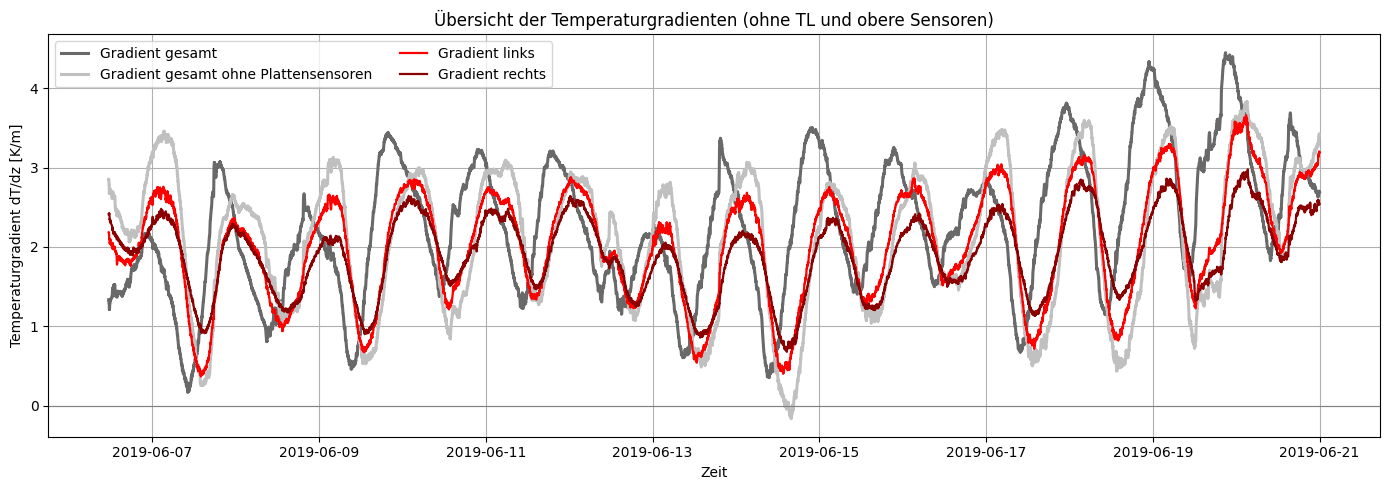

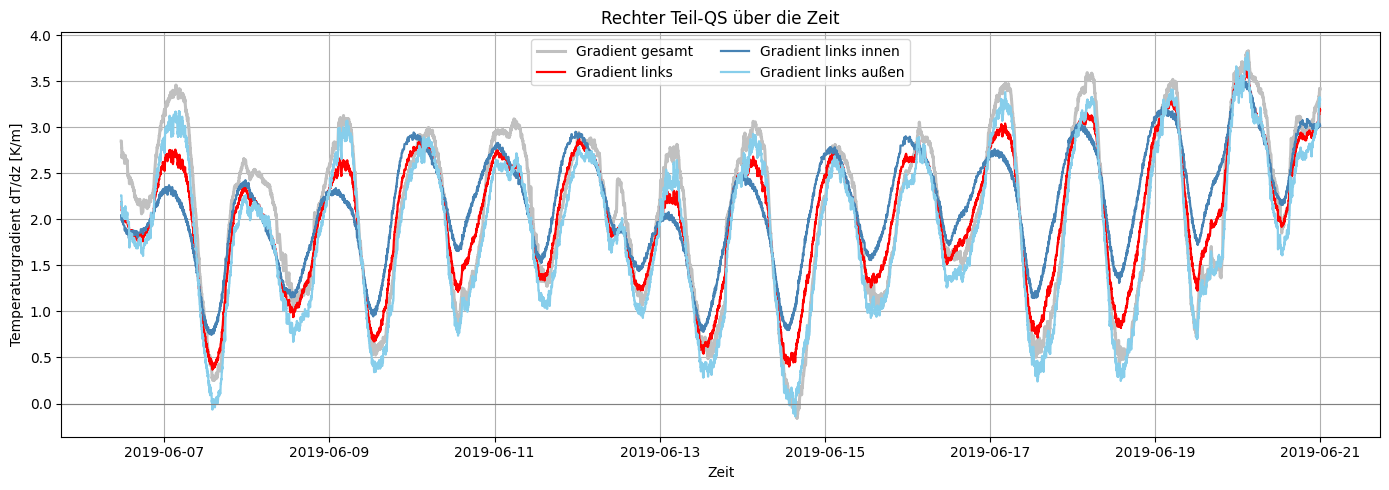

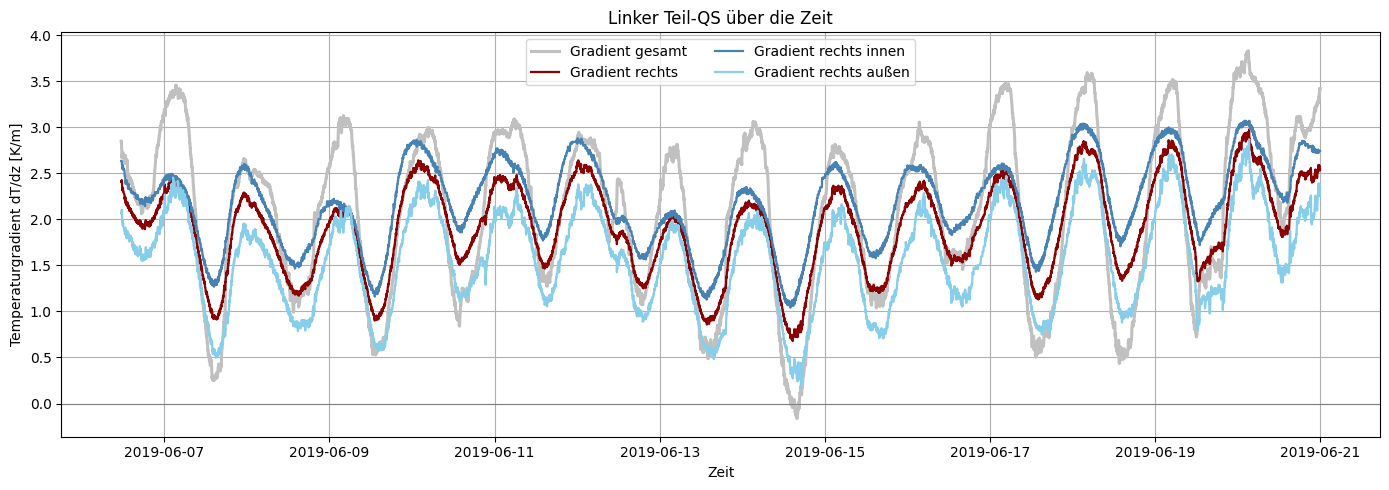

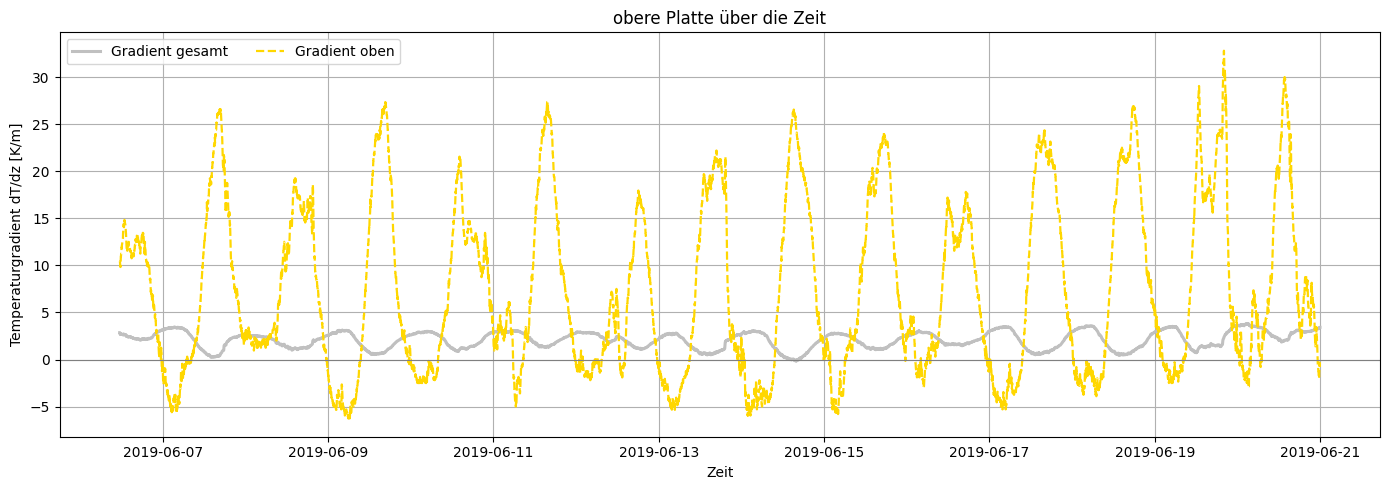

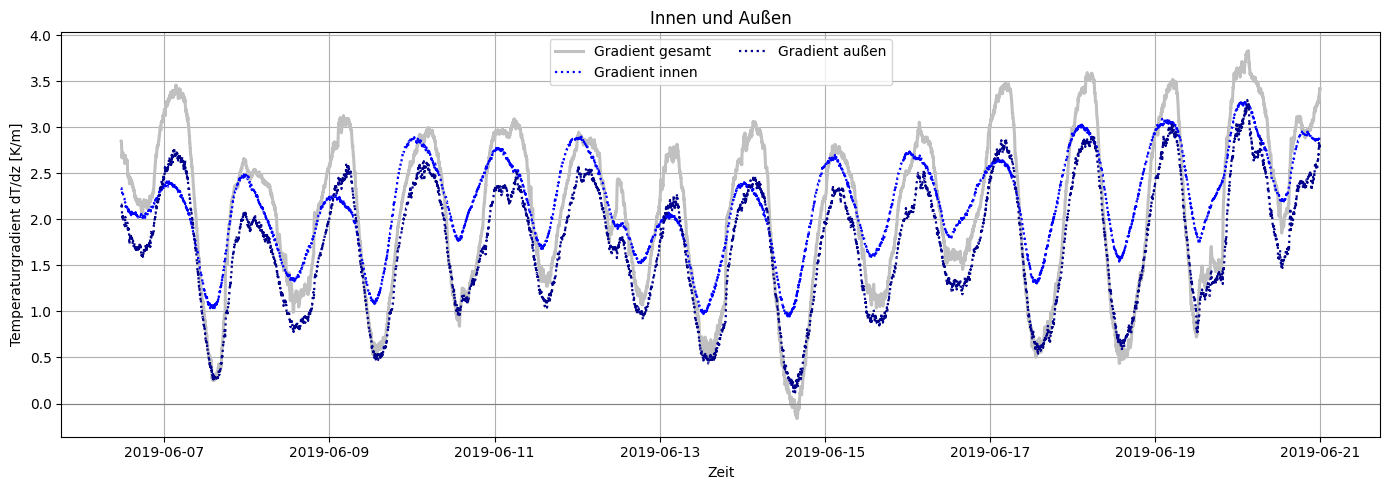

'\n    T7-9 sollten getrennt von anderen Gruppen betrachtet werden, da die Amplituden um ein Vielfaches höher und sind, eine Phasenverschiebung vorhanden ist und selsbt im Winter die Minima des Sommers nicht erreicht werden\n    alle anderen Sensorgruppen (innen, außen, links, rechts und deren Kombination) haben ähnliche Amplituden und Phasen\n        -im Sommer Maxima bis 5 und Minima bis -1; im Winter Maxima bis 2 und Minima bis -1,5\n    je mehr Sensoren einbezogen werden, desto weniger Ausreißer gibt es\n\n'

In [34]:
temperaturgradient("2019-06-06", "2019-06-20")

"""
    T7-9 sollten getrennt von anderen Gruppen betrachtet werden, da die Amplituden um ein Vielfaches höher und sind, eine Phasenverschiebung vorhanden ist und selsbt im Winter die Minima des Sommers nicht erreicht werden
    alle anderen Sensorgruppen (innen, außen, links, rechts und deren Kombination) haben ähnliche Amplituden und Phasen
        -im Sommer Maxima bis 5 und Minima bis -1; im Winter Maxima bis 2 und Minima bis -1,5
    je mehr Sensoren einbezogen werden, desto weniger Ausreißer gibt es
    
"""